# Выбор локации для скважины

## Описание проекта

Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль и проанализировать возможную прибыль и риски техникой Bootstrap.

## Техническое задание
1. **Предобработка данных**
    - Исследовать пропуски
    - Исследовать аномальные значения
    - Ислледовать распределения признаков
2. **Исследовательский анализ**
    - Рассмотреть все признаки в разрезе целевого признака
3. **Корреляционный анализ**
    - Исследовать данные на мультиколлениарность
4. **Подготовака данных**
    - Подготовить данные для работы с моделью линейной регрессии
5. **Созданеи модели**
    - Создать модель лмнейной регрессии для каждого региона
    - Проверить ее метрику RMSE
    - Проверить распределение и дисперсию остатков
    - Посмотреть среднее предсказанное значение
    - Сохранить истинные тестовые и предсказанные по ним значения в один датафрейм
6. **Подготовка для рассчета прибыли**
    - Рассчитать сколько должно быть запасов в скважине, чтобы она не приносила убытков
7. **Созданеи функции для рссчета прибыли, рассчет прибыли и рисков**
    - Создать функцию которая рассчитывает прибыль для региона методом Bootstrap
    - Проверить среднее значение прибыли по каждому региину
    - Найти 95%-й доверительный интервал
    - Определить риски убытков для каждого региона
8. **Написать общий вывод**

## Все необходимые установки и импорты

In [1]:
!pip install ydata-profiling -q
!pip install shap -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.2.6 requires pydantic!=1.8,!=1.8.1,<1.9.0,>=1.7.4, but you have pydantic 2.6.4 which is incompatible.
spacy 3.2.6 requires typing-extensions<4.6.0,>=3.7.4.1, but you have typing-extensions 4.10.0 which is incompatible.
thinc 8.0.17 requires pydantic!=1.8,!=1.8.1,<1.9.0,>=1.7.4, but you have pydantic 2.6.4 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import phik


from ydata_profiling import ProfileReport
from phik.report import plot_correlation_matrix

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

## Все используемые самописные функции

In [3]:
def scatterplot_creator(df: pd.DataFrame,
                        parametr_x: str,
                        parametr_y: str,
                        title: str,
                        xlabel: str,
                        ylabel: str,
                        hue=None, 
                       ) -> None:
    
    '''
    Функция принимает на фход датафрейм, параметры по которым будет строиться график и 
    именя для оглавления всего графиков и имен осей. По заданным параметрам функция 
    нарисует диаграмму рассеяния и отобразит коэффициент корреляции.
    
    Функция ничего не возвращает.
    '''
    
    sns.set()
    plt.figure(figsize=(9,9)),
    sns.scatterplot(
        data=df,
        x=parametr_x,
        y=parametr_y,
        hue=hue
    )
    plt.title(title,
              fontsize=20,
              fontweight='bold'
             )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    display(df[[parametr_y, parametr_x]].corr())

In [4]:
def histogram_creator(df: pd.DataFrame,
                      parametr:str,
                      bins: int,
                      title: str,
                      xlabel: str,
                      ylabel: str,
                      hue=None
                     ) -> None:
   
    '''
    Функция принимает в качестве параметров датафрейм, параметр (название столбца)
    по которому будет строится гистограмма, число бинов и строки с названием всего графика,
    оси Ox и оси Oy, соответственно.
   
    На выходе функция не возвращает ничего. Функция строит гистограмму по заданному параметру.
    ''' 

    sns.set()
    plt.figure(figsize=(15, 8))
    sns.histplot(data=df,
                 x=parametr,
                 bins=bins,
                 color='#4f4d49',
                 edgecolor='black',
                 kde=True
    )
    plt.title(title,
              fontsize=20,
              fontweight='bold'
             )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    display(df[parametr].describe())

In [5]:
RANDOM_STATE = 42
def prepare_data(df: pd.DataFrame) -> pd.DataFrame:
    
    '''
     Функция принимает на вход датафрейм и подготавливает его к работе модели, скейлит и разделяет на выборки.   
    '''
    
    X = df.loc[:, ['f0', 'f1', 'f2']]
    y = df['product']

    X_train, X_valid, y_train, y_valid = train_test_split(
        X,
        y,
        test_size=0.25,
        random_state=RANDOM_STATE
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_train = pd.DataFrame(X_train, columns=['f0', 'f1', 'f2'])
    X_valid = pd.DataFrame(X_valid, columns=['f0', 'f1', 'f2'])
    
    return X_train, X_valid, y_train, y_valid

In [6]:
def residuals(y_valid: pd.DataFrame, predictions: np.ndarray) -> None:
    
    '''
    Функция принимает на вход массив с истинными значениями и предсказанными и строит графики для анализа остатков и
    их дисперсии.
    '''
    
    residuals = y_valid - predictions
    residuals = pd.DataFrame(y_valid - predictions)
    histogram_creator(residuals,
                      'product',
                      40,
                      'Распределение остатков первой модели',
                      'Значение остатков',
                      'Число остатков'
                     )

    residuals['predictions'] = predictions
    scatterplot_creator(residuals, 
                        'predictions',
                        'product',
                        'Изучение дисперсии остатков',
                        'Значение предсказания',
                        'Значение ошибки'
                       )

In [7]:
def make_results_df(y_valid: pd.DataFrame, predictions: np.ndarray) -> pd.DataFrame:
    
    '''
    Функия принимает на вход массив с истинными значениями и предсказанными, составляет из них общий датафрейм, т.е.
    результат работы модели.
    '''
    
    predictions = pd.Series(predictions, index=y_valid.index)
    results = pd.concat([y_valid, predictions], axis=1)
    results.rename(
        columns={
            0 : 'predictions',
        },
        inplace=True
    )
    
    return results

## Загрузка и знакомство с данными

In [8]:
try:
    geo_0 = pd.read_csv('datasets/geo_data_0.csv')
except:
    geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_0.head()

id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

In [9]:
try:
    geo_1 = pd.read_csv('datasets/geo_data_1.csv')
except:
    geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_1.head()

id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305

In [10]:
try:
    geo_2 = pd.read_csv('datasets/geo_data_2.csv')
except:
    geo_2 = pd.read_csv('/datasets/geo_data_2.csv')
geo_2.head()

id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746

### Вывод по загрузке данных
 
На первый взгляд никаких проблем в данных не обнаружено. Все датасеты загружены в датафреймы pandas.

## Предобработка данных

### geo_0

Для начала сделаем id индексом, для удобства, проверим типы данных, дубликаты и пропуски, потом уже распределение значений по каждому параметру.

In [11]:
geo_0.set_index('id', inplace=True)
geo_0.head()

f0        f1        f2     product
id                                             
txEyH  0.705745 -0.497823  1.221170  105.280062
2acmU  1.334711 -0.340164  4.365080   73.037750
409Wp  1.022732  0.151990  1.419926   85.265647
iJLyR -0.032172  0.139033  2.978566  168.620776
Xdl7t  1.988431  0.155413  4.751769  154.036647

In [12]:
print('Число полных дубликатов в данных:', geo_0.duplicated().sum())

Число полных дубликатов в данных: 0


Полных дубликатов в даннх не обнаружено.

In [13]:
print('Число пропусков в данных:\n', geo_0.isna().sum())

Число пропусков в данных:
 f0         0
f1         0
f2         0
product    0
dtype: int64


Пропусков не обнаружено.

In [14]:
geo_0.dtypes

f0         float64
f1         float64
f2         float64
product    float64
dtype: object

Все типы соответствуют действительности. Теперь можно взнлянуть на распределения для этого воспользуемся библиотекой ydata-profiling.

In [15]:
profile_geo_0 = ProfileReport(geo_0, title="Profiling report for geo_0")
profile_geo_0.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Все распределения кроме f2 вглядят очень интересно. Только признак f2 распределен нормально, но другие распределения мы никак отредактировать не можем, потому что по условию задачи не сказано, что это за признаки, следовательно мы не можем судить как они должны быть распределены. Можно лишь отметить, что есть одна скважина с 0 показателем объема запасов, предлагаю взглянуть на ее характеристики, но не удалять ее так, как она будет влиять на прибыльность региона.

In [16]:
geo_0[geo_0['product'] == 0]

f0        f1        f2  product
id                                          
zCM5W -0.702064  0.375992  0.236572      0.0

Опять же трудно как-либо интерпритировать эти данные изз абстрактности задачи.

### geo_1

Для начала сделаем id индексом, для удобства, проверим типы данных, дубликаты и пропуски, потом уже распределение значений по каждому параметру.

In [17]:
geo_1.set_index('id', inplace=True)
geo_1.head()

f0         f1        f2     product
id                                               
kBEdx -15.001348  -8.276000 -0.005876    3.179103
62mP7  14.272088  -3.475083  0.999183   26.953261
vyE1P   6.263187  -5.948386  5.001160  134.766305
KcrkZ -13.081196 -11.506057  4.999415  137.945408
AHL4O  12.702195  -8.147433  5.004363  134.766305

In [18]:
print('Число полных дубликатов: ', geo_1.duplicated().sum())

Число полных дубликатов:  0


Полных дубликатов значений не обнаружено.

In [19]:
print('Число пропусков в данных:\n', geo_1.isna().sum())

Число пропусков в данных:
 f0         0
f1         0
f2         0
product    0
dtype: int64


Пропусков в даннх не обнаружено.

In [20]:
geo_1.dtypes

f0         float64
f1         float64
f2         float64
product    float64
dtype: object

Все типы соответствуют действительности. Теперь можно взнлянуть на распределения для этого воспользуемся библиотекой ydata-profiling.

In [21]:
profile_geo_1 = ProfileReport(geo_1, title="Profiling report for geo_1")
profile_geo_1.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

В этом датафрейме почти все распределения (кроме f1) вглядят очень интересно. Параметр f1 единственный, который распределен нормально. Параметр f0 имеет два пика, а вот данные в f2 и product похожи на исскуственно сгенерированные, но опять же мы не можем ничего сказать, потому что мы не знаеем, что это за признаки и как они могут быть распределены. Можно только отметить, что в этом регионе много скважин с нулевым показателем объемов запасов - это не выгодно для региона.

### geo_2

Для начала сделаем id индексом, для удобства, проверим типы данных, дубликаты и пропуски, потом уже распределение значений по каждому параметру.

In [22]:
geo_2.set_index('id', inplace=True)
geo_2.head()

f0        f1        f2     product
id                                             
fwXo0 -1.146987  0.963328 -0.828965   27.758673
WJtFt  0.262778  0.269839 -2.530187   56.069697
ovLUW  0.194587  0.289035 -5.586433   62.871910
q6cA6  2.236060 -0.553760  0.930038  114.572842
WPMUX -0.515993  1.716266  5.899011  149.600746

In [23]:
print('Число полных дубликатов: ', geo_2.duplicated().sum())

Число полных дубликатов:  0


Полных дубликатов в данных не обнаружено.

In [24]:
print('Число пропусков в данных:\n', geo_1.isna().sum())

Число пропусков в данных:
 f0         0
f1         0
f2         0
product    0
dtype: int64


Пропусков в данных не обнаружено.

In [25]:
geo_2.dtypes

f0         float64
f1         float64
f2         float64
product    float64
dtype: object

Все типы соответствуют действительности. Теперь можно взнлянуть на распределения для этого воспользуемся библиотекой ydata-profiling.

In [26]:
profile_geo_2 = ProfileReport(geo_2, title="Profiling report for geo_2")
profile_geo_2.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Этот датафрейм отличается от других тем, что все признаки (f0, f1, f2) распределены нормально, а f0, f2, даже без смещения. Распределение product все еще выглядит необычно, но тут в отличае от прошлого датафрейма всего одмн нулевой показатель объема запасов.

### Общий вывод по предобработке данных

**geo_0**

- Только признак f2 распределен нормально, но другие распределения мы никак отредактировать не можем, потому что по условию задачи не сказано, что это за признаки, следовательно мы не можем судить как они должны быть распределены.
- Среднее значение объема запасов равно - 92.5, медианное - 91.849972

**geo_1**

- Параметр f1 единственный, который распределен нормально. Параметр f0 имеет два пика, а вот данные в f2 и product похожи на исскуственно сгенерированные, но опять же мы не можем ничего сказать, потому что мы не знаеем, что это за признаки и как они могут быть распределены.
- В данном датафрейме много нулевых значений показателя объема запасов
- Среднее занчение объема запасов равно - 68.825, медианное - 57.085625, достаточно большой разброс

**geo_2**

- Этот датафрейм отличается от других тем, что все признаки (f0, f1, f2) распределены нормально, а f0, f2, даже без смещения.
- Среднее значение объема запаосов рано - 95, медианное - 94.925613

## Исследовательский анализ данных

На этом этапе необходимо рассмотреть все признаки в разрезе целевого признака.

### geo_0

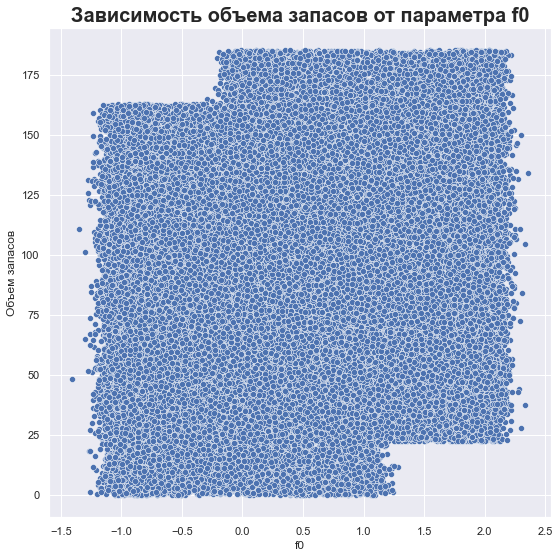

product        f0
product  1.000000  0.143536
f0       0.143536  1.000000

In [27]:
scatterplot_creator(geo_0,
                    'f0',
                    'product',
                    'Зависимость объема запасов от параметра f0',
                    'f0',
                    'Объем запасов'
                   )

Трудно выявить какую либо зависимость, ее скорее нет, есть только странное отсутвие значений в правом нижнем и левом верхнем углу графика. Можно попробовать найти эту зависимость для 1000 рандомных точек.

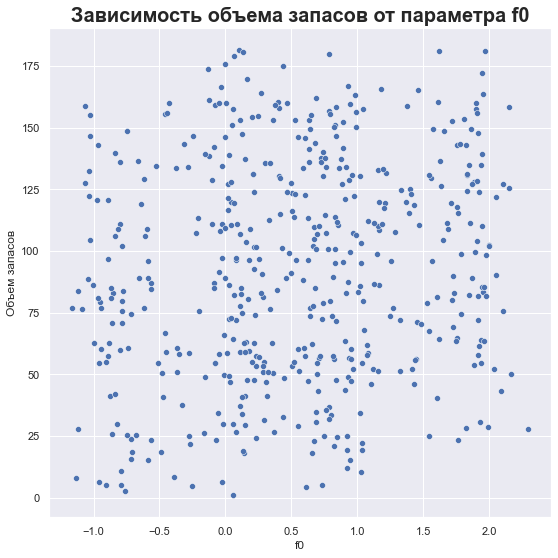

product       f0
product  1.00000  0.15096
f0       0.15096  1.00000

In [28]:
scatterplot_creator(geo_0.sample(500),
                    'f0',
                    'product',
                    'Зависимость объема запасов от параметра f0',
                    'f0',
                    'Объем запасов'
                   )

Зависимости все еще не наблюдается, об этом говорит и полученный коэффициент корреляции.

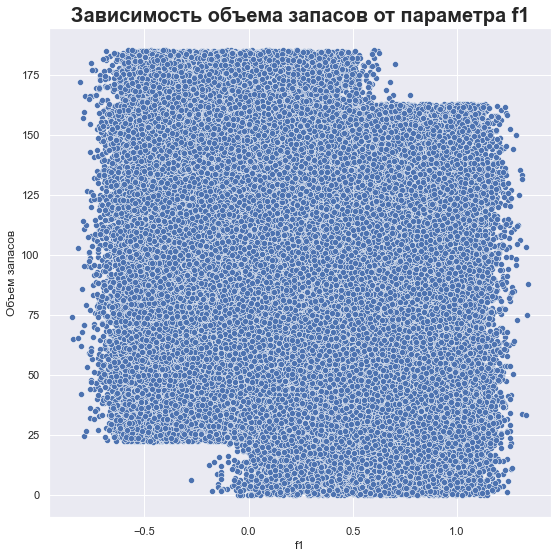

product        f1
product  1.000000 -0.192356
f1      -0.192356  1.000000

In [29]:
scatterplot_creator(geo_0,
                    'f1',
                    'product',
                    'Зависимость объема запасов от параметра f1',
                    'f1',
                    'Объем запасов'
                   )

График выглядит почти как прошлый, только пустые углы стали инверсными, опять же проследить какую либо зависимость врядли воможно. Попробуем разглядеть ее на выборке с 1000 рандомных значений.

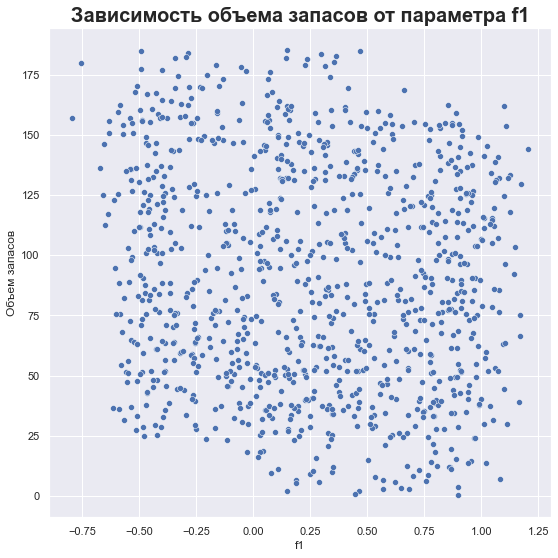

product        f1
product  1.000000 -0.125303
f1      -0.125303  1.000000

In [30]:
scatterplot_creator(geo_0.sample(1000),
                    'f1',
                    'product',
                    'Зависимость объема запасов от параметра f1',
                    'f1',
                    'Объем запасов'
                   )

Если постараться, можно разглядеть, что значения немного растянуты от верхнего левого угла к нижнему правому, об этом говорит и отрицательный коэффициент корреляции, но он тоже очень не значительный, чтобы говорить о какой либо зависимости.

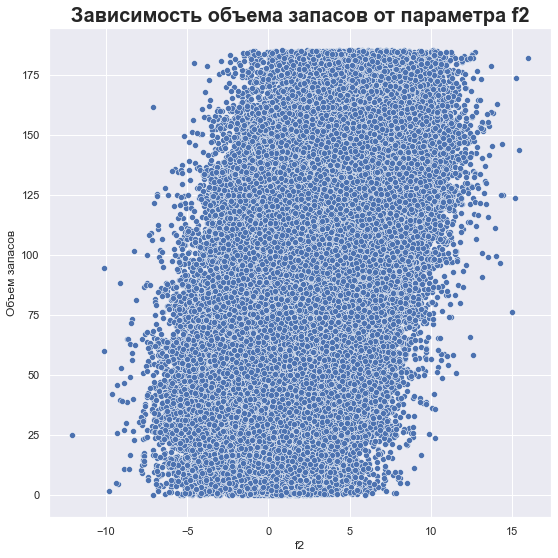

product        f2
product  1.000000  0.483663
f2       0.483663  1.000000

In [31]:
scatterplot_creator(geo_0,
                    'f2',
                    'product',
                    'Зависимость объема запасов от параметра f2',
                    'f2',
                    'Объем запасов'
                   )

Тут уже зависимость более явная, можно сказать, что чем больше признак f2, тем более высокое значение будет у объема запасов. Коэффициент корреляции все еще не значительный.

### geo_1

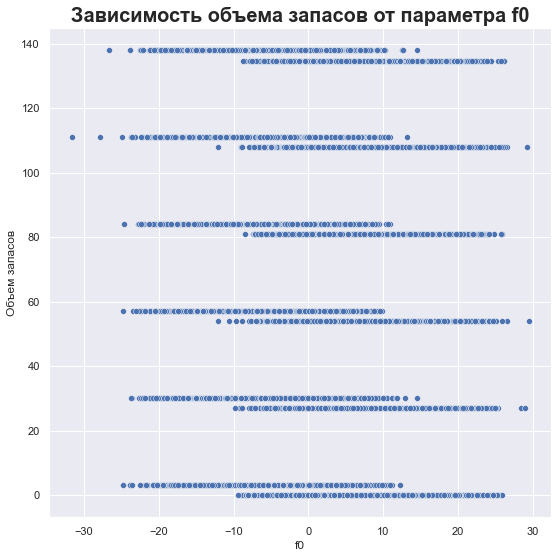

product        f0
product  1.000000 -0.030491
f0      -0.030491  1.000000

In [32]:
scatterplot_creator(geo_1,
                    'f0',
                    'product',
                    'Зависимость объема запасов от параметра f0',
                    'f0',
                    'Объем запасов'
                   )

Тут уже график выглядит интересно, очень похоже на то, что значение объема запасов исскуственное или очень грубо округлено, но это не меняет того, что никакой зависимости в данных нет.

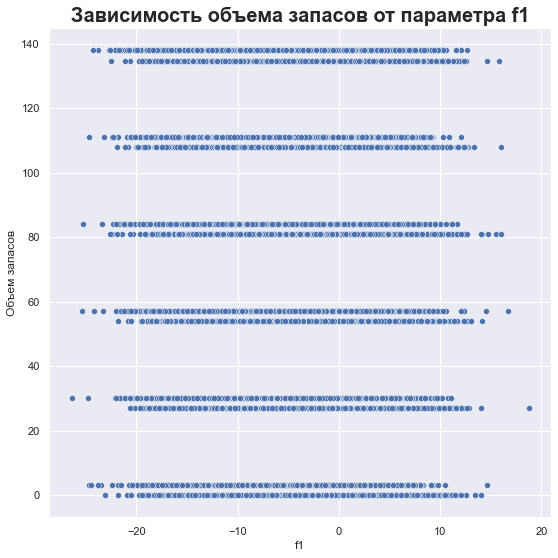

product        f1
product  1.000000 -0.010155
f1      -0.010155  1.000000

In [33]:
scatterplot_creator(geo_1,
                    'f1',
                    'product',
                    'Зависимость объема запасов от параметра f1',
                    'f1',
                    'Объем запасов'
                   )

Опять же данные похожи на исскуственные и опять же нет никакой зависимости.

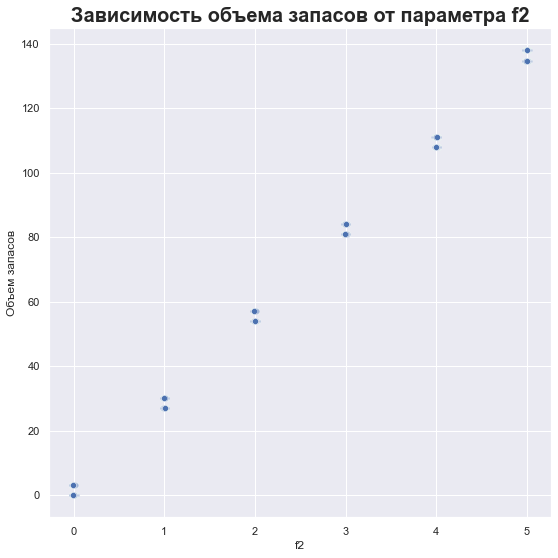

product        f2
product  1.000000  0.999397
f2       0.999397  1.000000

In [34]:
scatterplot_creator(geo_1,
                    'f2',
                    'product',
                    'Зависимость объема запасов от параметра f2',
                    'f2',
                    'Объем запасов'
                   )

Тут данные максимально похожи на исскуственные, все уровни объема запасов сливаются в одну точку. Опять же мы над этим не влястны, какие данные - такой результат, можно только отметить только наличие однозначной линейной зависимсти.

### geo_2

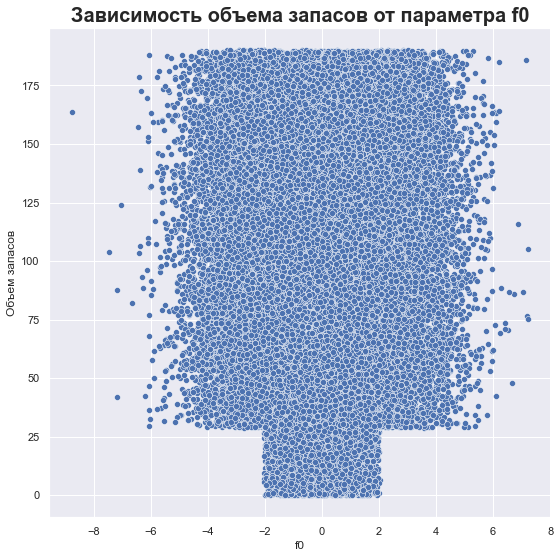

product        f0
product  1.000000 -0.001987
f0      -0.001987  1.000000

In [35]:
scatterplot_creator(geo_2,
                    'f0',
                    'product',
                    'Зависимость объема запасов от параметра f0',
                    'f0',
                    'Объем запасов'
                   )

Очень странный рисунок, можно отметить, что точки запасы которых не превышают 25-30 имеют диапозон значений параметра f0 от -2 до 2. Предлагаю посмотерть зависимость на 1000 рандомных точках, так как тут разглядеть зависимость очень тяжело.

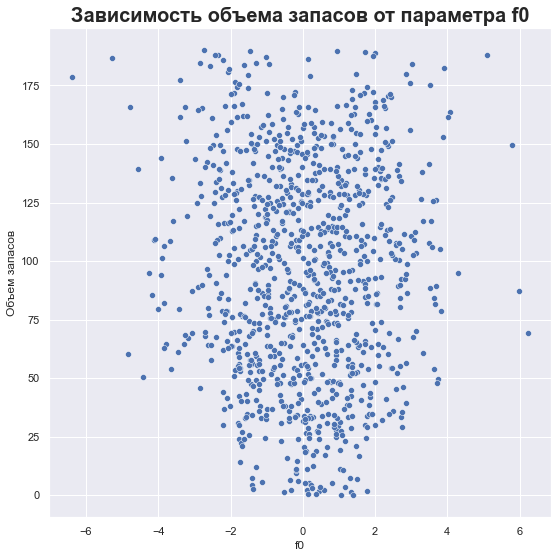

product        f0
product  1.000000 -0.018316
f0      -0.018316  1.000000

In [36]:
scatterplot_creator(geo_2.sample(1000),
                    'f0',
                    'product',
                    'Зависимость объема запасов от параметра f0',
                    'f0',
                    'Объем запасов'
                   )

Примерно такой же "рисунок", так что никакой зависимости кроме отмечанной выше нет.

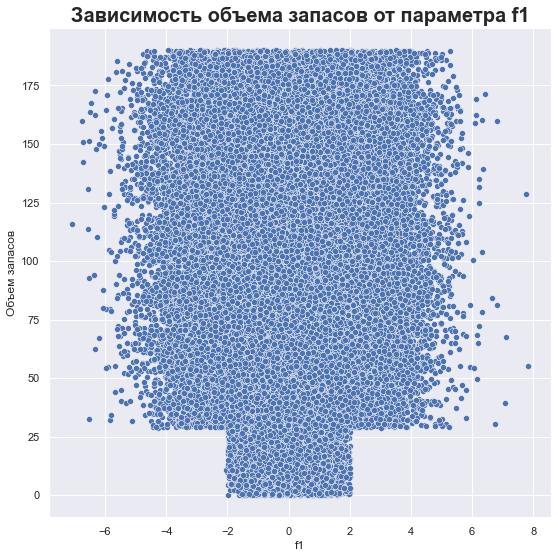

product        f1
product  1.000000 -0.001012
f1      -0.001012  1.000000

In [37]:
scatterplot_creator(geo_2,
                    'f1',
                    'product',
                    'Зависимость объема запасов от параметра f1',
                    'f1',
                    'Объем запасов'
                   )

Зависимость выглядит и ведет себя точно как и в признке f1, можно попробовать посмотреть на 1000 рандомных значений.

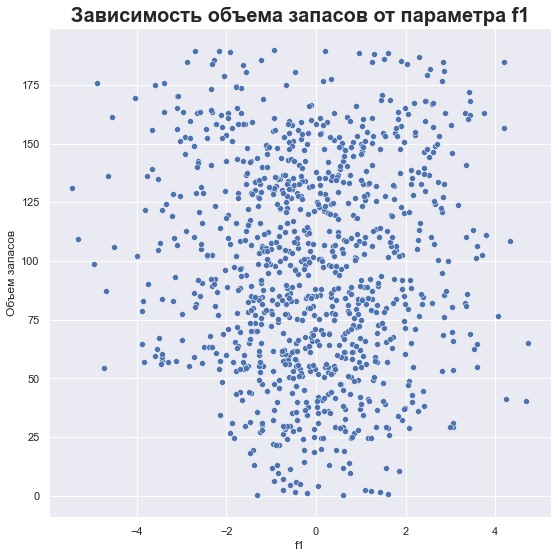

product        f1
product  1.000000 -0.018406
f1      -0.018406  1.000000

In [38]:
scatterplot_creator(geo_2.sample(1000),
                    'f1',
                    'product',
                    'Зависимость объема запасов от параметра f1',
                    'f1',
                    'Объем запасов'
                   )

Вывод тот же - никакой зависимости кроме отмечанной выше.

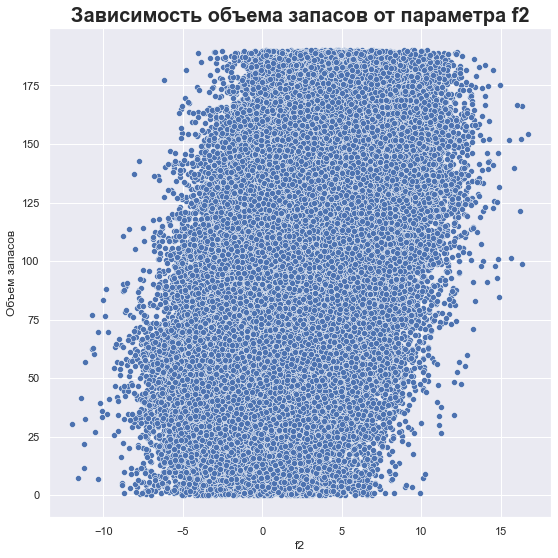

product        f2
product  1.000000  0.445871
f2       0.445871  1.000000

In [39]:
scatterplot_creator(geo_2,
                    'f2',
                    'product',
                    'Зависимость объема запасов от параметра f2',
                    'f2',
                    'Объем запасов'
                   )

Тут уже видна линейная зависимость, чем выше значение параметра f2, тем выше будет объем запасов.

### Вывод по исследовательскому анализу данных

**geo_0**

- Небольшая зависимость есть только между целевым признаком и параметром f2
- Точки у которых значение параметра f0 примерно меньше 0 не имеют значений объема запасов больше 160
- Точки у которых значение параметра f0 примерно больше 1 не имеют значений объема запасов меньше 25
- Точки у которых значение параметра f0 примерно меньше 0 не имеют значений объема запасов меньше 25
- Точки у которых значение параметра f0 примерно больше 0.5 не имеют значений объема запасов больше 160

**geo_1**

- Все данные очень похоже на исскуственно сгенерированные
- Парметры f0 и f1 не имеют никакой зависимости с целевым признаком
- Параметр f2 имет явную линейную зависимость с целевым прихнаком, чем больше f2, тем больше значение объемов запасов

**geo_2**

- Точки запасы которых не превышают 25-30 имеют диапозон значений параметров f0 и f1 от -2 до 2, линейная зависимость отсутсвует
- Целевой признак имет небольшую линейную зависимость от параметра f2, проще говоря чем больше f2, тем больше значение целевого признака.

## Корреляционный анализ

### geo_0

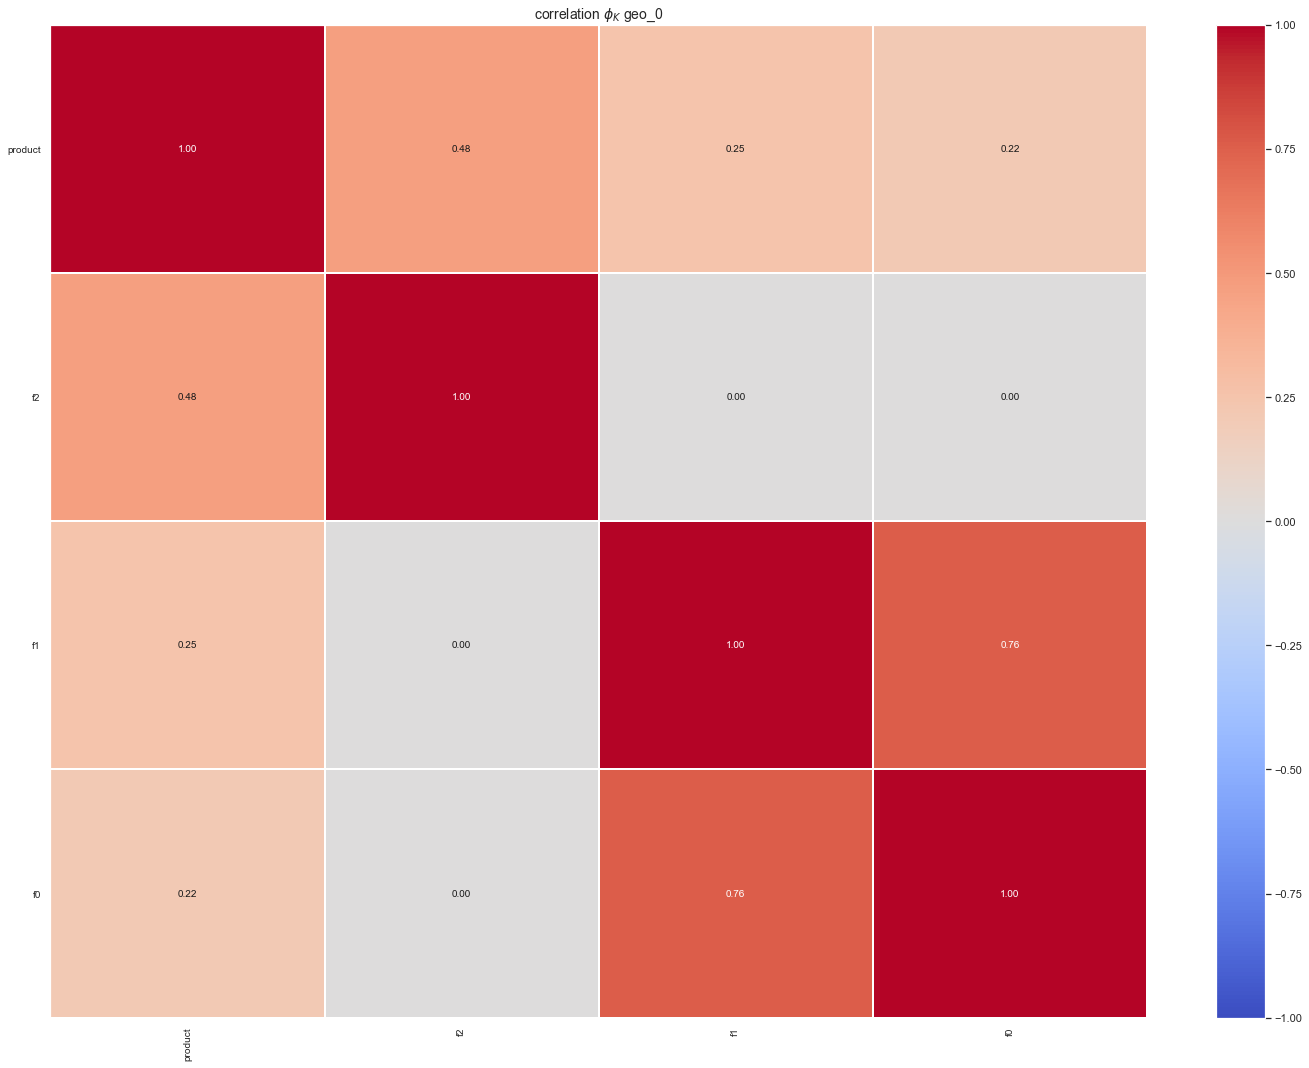

In [40]:
interval_cols = list(geo_0.columns)

phik_overview = geo_0.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r'correlation $\phi_K$ geo_0',
    color_map='coolwarm',
    figsize=(20, 15)
) 

Мультиколлениарность в данных датафрейма geo_0 отсутсвует.

### geo_1

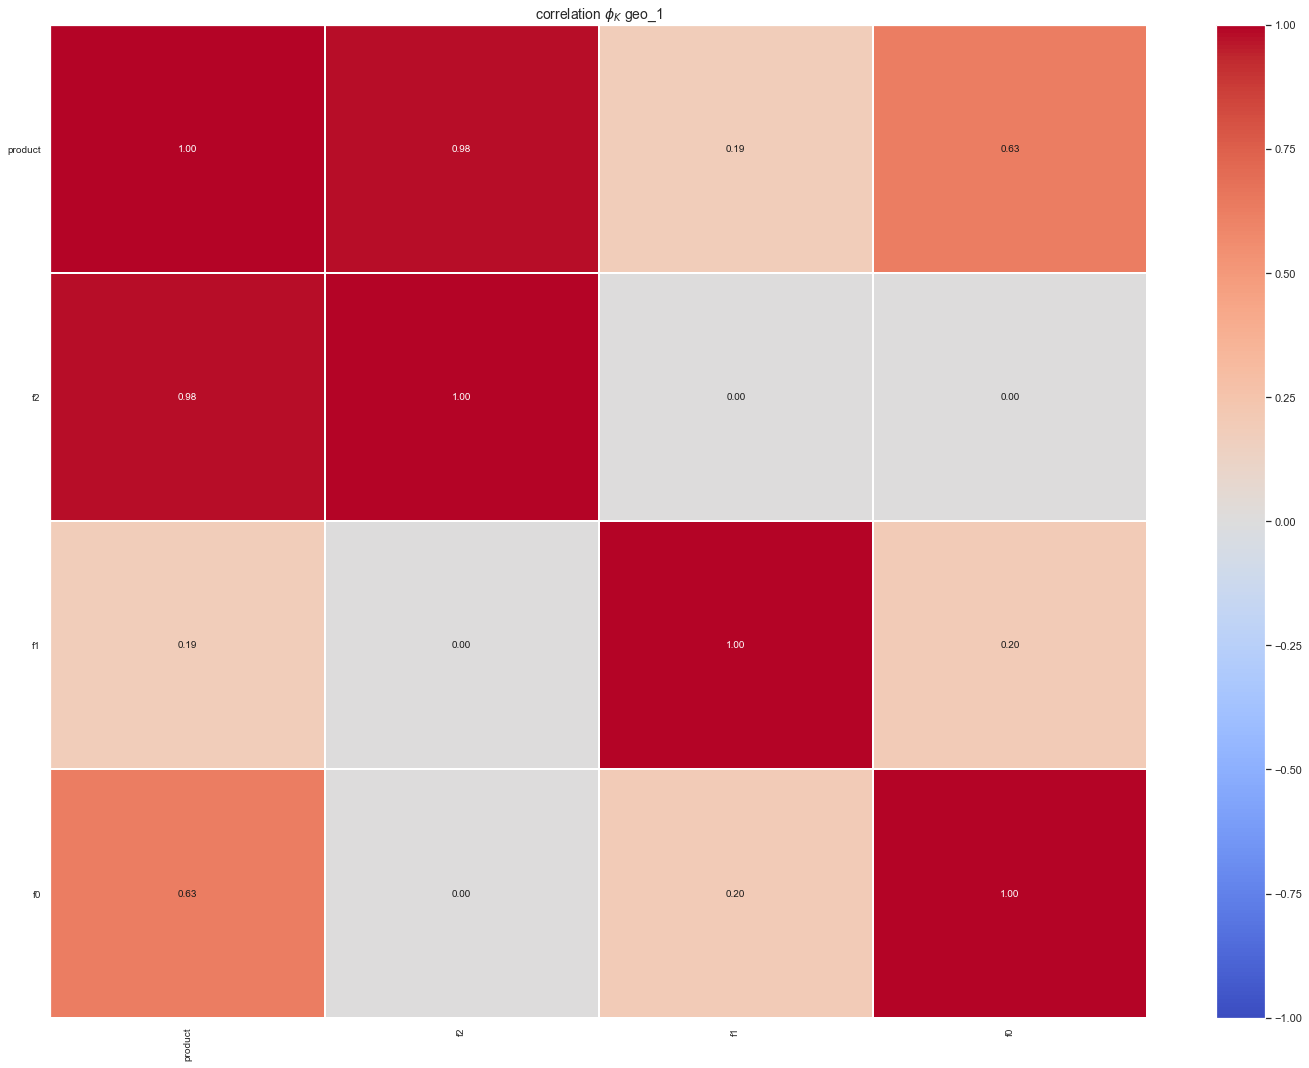

In [41]:
phik_overview = geo_1.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r'correlation $\phi_K$ geo_1',
    color_map='coolwarm',
    figsize=(20, 15)
) 

Тут мы видим то же, что и на этапе исследовательского анализа, но это корреляция с целеввым признаком, что допустимо. Мультиколленеарноость в данных отсутствует.

### geo_2

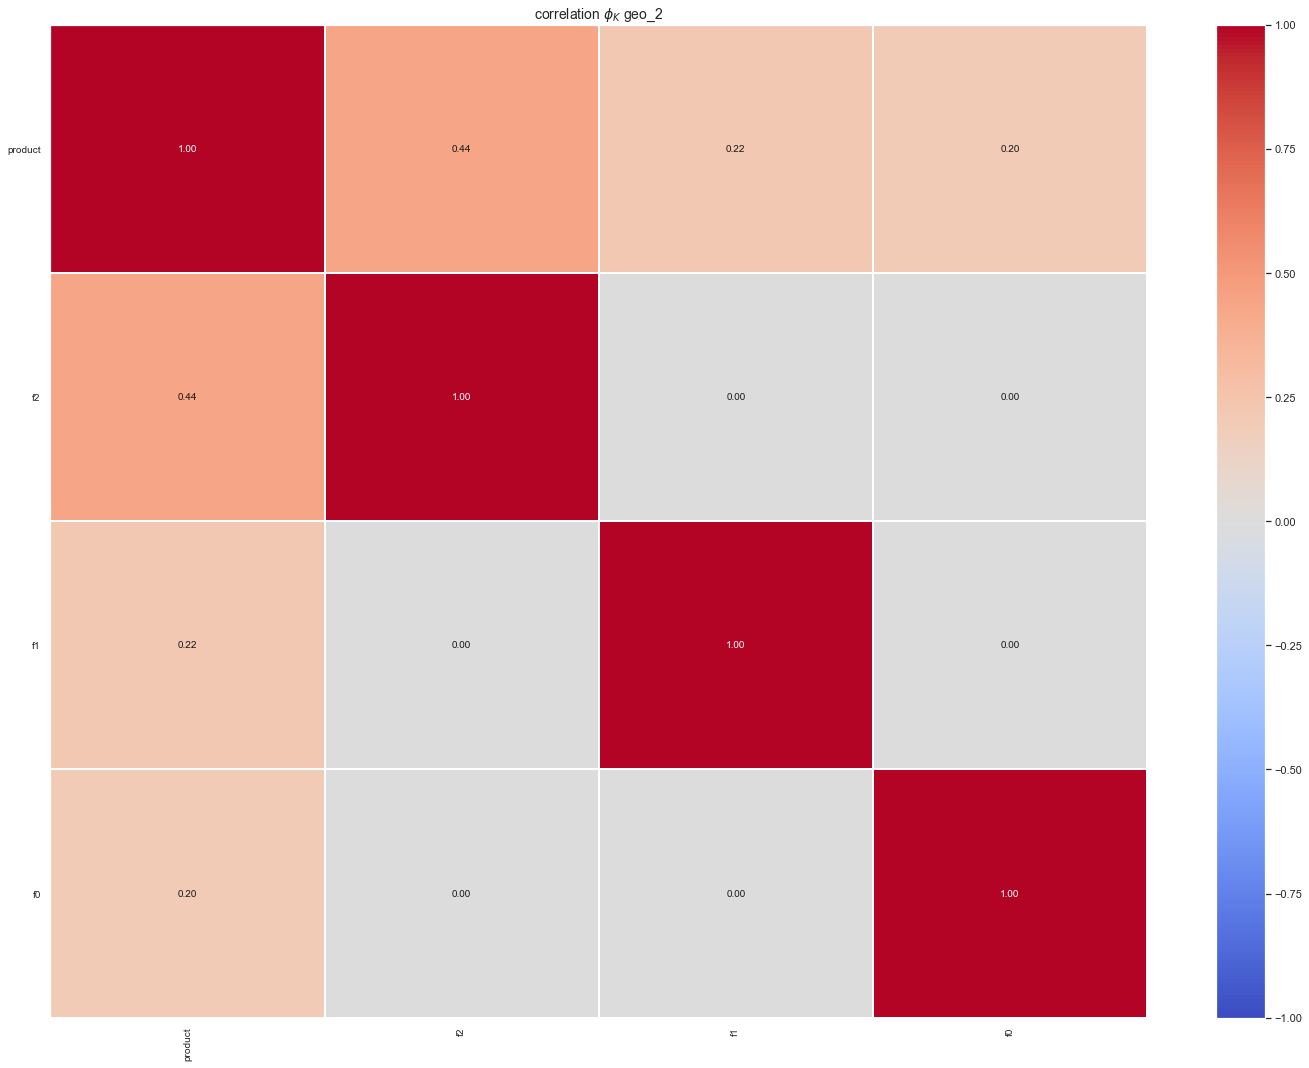

In [42]:
phik_overview = geo_2.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r'correlation $\phi_K$ geo_2',
    color_map='coolwarm',
    figsize=(20, 15)
) 

Тут у большинства параметров вообще нулевая корреляция. Мультиколлениарность в данных датафрейма geo_2 отсутсвует.

### Вывод по крреляционному анализу
Ни во одном из датафреймов параметры не коррелируют между собой. Мультиколленеарность в данных отсутсвует.

## Подготовка данных и создание модели

По условию задачи к этим данным подходит только модель линейной регресси, поэтому будем использовать только ее. Так же в условии задачи сказанно, что в качестве метрики необходимо использовать метрику RMSE. Для каждого из датафреймов будем строить свою модель для большей точности. Для подготовки данных буду использовать функцию написанную в пункте про все используемые самописные функции.

### geo_0

In [43]:
X_train_0, X_valid_0, y_train_0, y_valid_0 = prepare_data(geo_0) 
X_train_0.head()

f0        f1        f2
0  1.274786 -0.799739 -0.396677
1 -1.600689  0.234678 -2.169283
2 -0.323791  1.436297  1.495425
3  0.439038  0.830679  0.185881
4 -1.652805  0.761012  0.111734

In [44]:
model_0 = LinearRegression(n_jobs=-1)
model_0.fit(X_train_0, y_train_0)
predictions_0 = model_0.predict(X_valid_0)
predictions_0[:5]

array([101.90101715,  78.21777385, 115.26690103, 105.61861791,
        97.9801849 ])

Модель полностью готова, теперь посмотрм какое значение метрики она показывает.

In [45]:
rmse_0 = mean_squared_error(y_valid_0, predictions_0, squared=False)
print(f'Значение метрики RMSE на валидационной выборке равно {round(rmse_0, 2)}')

Значение метрики RMSE на валидационной выборке равно 37.76


Отлично, значение метрики корня среднеквадратической ошибки не такое большое, значит модель работает достаточно точно. Cледует проверить работу модели при помощи еще нескольких инструментов, я имею ввиду распределение и дисперсию остатков. Для этого буду использовать функцию описанную в пункте "все используемые самописные функции".

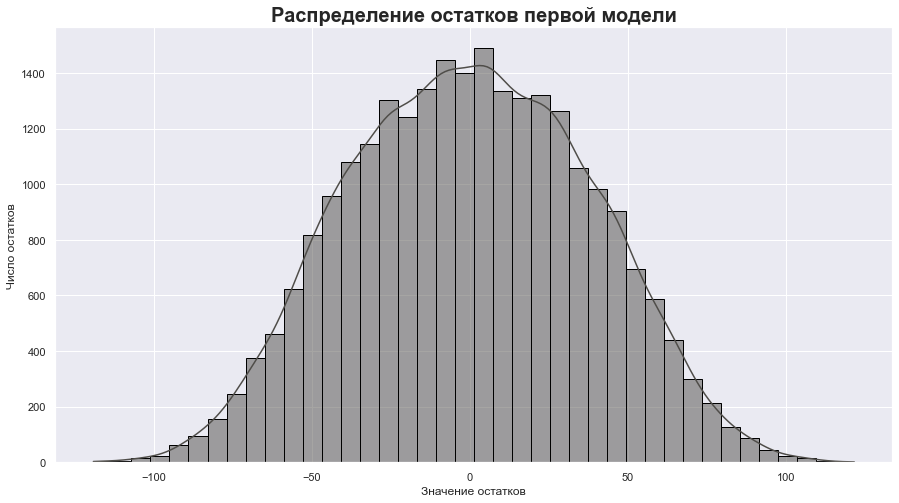

count    25000.000000
mean        -0.072844
std         37.757285
min       -119.074439
25%        -27.917279
50%         -0.098192
75%         27.594907
max        121.520866
Name: product, dtype: float64

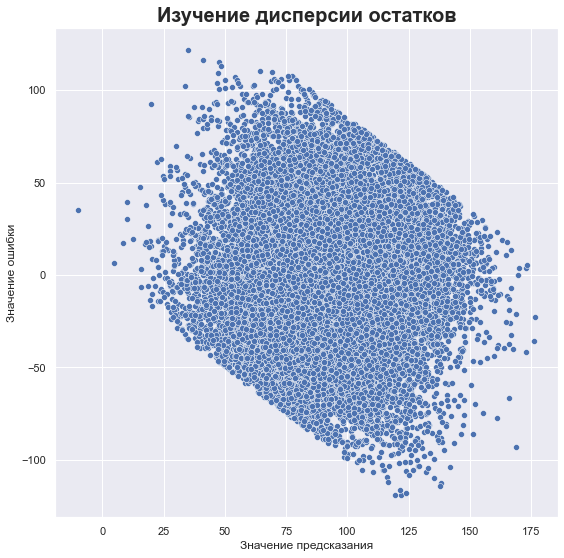

product  predictions
product      1.000000    -0.002378
predictions -0.002378     1.000000

In [46]:
residuals(y_valid_0, predictions_0)

Распределение остатков выглядит отлично, это нормальное распределение без хвостов и сдвигов, это значит, что модель работает предсказуемо. Теперь посмотрим на дисперсию остатков.

Все данные рапределены достаточно густо - это значит, что дисперсия не большая и модель работает предсказуемео.

Теперь посморим на среднее значение предсказанного количества сырья.

In [47]:
print(f'Среднее значение предсказанного количества сырья равно {round(predictions_0.mean(), 2)}')

Среднее значение предсказанного количества сырья равно 92.4


Тепрь необходимо сохранить результат, а точнее истинные значения объема запасов и предсказанные в один датафрейм. Для этого опять же буду использовать самописную функцию описанную в начале прокта.

In [48]:
results_0 = make_results_df(y_valid_0, predictions_0)
results_0.head()

product  predictions
id                            
7C6bA  122.073350   101.901017
dVxsn   48.738540    78.217774
1Gm3l  131.338088   115.266901
Nzg1t   88.327757   105.618618
Z7b4F   36.959266    97.980185

Отлично, результат по первой модели и сама модель полностью готовы.

### geo_1

In [49]:
X_train_1, X_valid_1, y_train_1, y_valid_1 = prepare_data(geo_1) 
X_train_1.head()

f0        f1        f2
0  0.911229  0.063780 -0.291331
1  1.640885  1.320793  1.463778
2 -0.303818  0.859595  0.297952
3  1.250304 -0.332629 -0.290244
4 -0.678630 -0.629111 -0.877242

In [50]:
model_1 = LinearRegression(n_jobs=-1)
model_1.fit(X_train_1, y_train_1)
predictions_1 = model_1.predict(X_valid_1)
predictions_1[:5]

array([ 8.44738063e-01,  5.29216119e+01,  1.35110385e+02,  1.09494863e+02,
       -4.72915824e-02])

In [51]:
rmse_1 = mean_squared_error(y_valid_1, predictions_1, squared=False)
print(f'Значение метрики RMSE на валидационной выборке равно {round(rmse_1, 2)}')

Значение метрики RMSE на валидационной выборке равно 0.89


Значение метрики корня среднеквадратической ошибки получилось очень маленькой, нужно проверить как распределены остатки и какая дисперсия у предсказанных значений

In [52]:
y_valid_1.head()

id
fYVDK      0.000000
3SQcq     53.906522
hQ1gJ    134.766305
Y4vux    107.813044
H1NUw      0.000000
Name: product, dtype: float64

Действительно модель получилась очень точной, у данных не большой разброс. Возможно это связанно с тем, что в этом датафрейме у одного признака была сильная линейная зависимость с целевым признаком. Нужно посмотреть на среднне предсказанное значение объема запасов. Так же стоит записать предсказания модели и истинные значения в один датафрейм.

In [53]:
print(f'Среднее значение предсказанного количества сырья равно {round(predictions_1.mean(), 2)}')

Среднее значение предсказанного количества сырья равно 68.71


In [54]:
results_1 = make_results_df(y_valid_1, predictions_1)
results_1.head()

product  predictions
id                            
fYVDK    0.000000     0.844738
3SQcq   53.906522    52.921612
hQ1gJ  134.766305   135.110385
Y4vux  107.813044   109.494863
H1NUw    0.000000    -0.047292

Предлагаю поменять все отрицательные значения, на нули - это просто погрешность работы модели и все эти значения и так крайне маленькие.

In [55]:
results_1.loc[results_1['predictions'] < 0, 'predictions'] = 0
results_1.head()

product  predictions
id                            
fYVDK    0.000000     0.844738
3SQcq   53.906522    52.921612
hQ1gJ  134.766305   135.110385
Y4vux  107.813044   109.494863
H1NUw    0.000000     0.000000

Отлично, вторая моедль и ее результаты полностью готовы.

### geo_2

In [56]:
X_train_2, X_valid_2, y_train_2, y_valid_2 = prepare_data(geo_2) 
X_train_2.head()

f0        f1        f2
0 -0.343864 -1.338311  0.817572
1 -0.400431  0.993613 -1.102974
2  1.004849 -0.923485 -0.576264
3 -0.784031  0.571573  0.914886
4  0.619771  0.681588 -0.429467

In [57]:
model_2 = LinearRegression(n_jobs=-1)
model_2.fit(X_train_2, y_train_2)
predictions_2 = model_2.predict(X_valid_2)
predictions_2[:5]

array([ 98.30191642, 101.59246124,  52.4490989 , 109.92212707,
        72.41184733])

In [58]:
rmse_2 = mean_squared_error(y_valid_2, predictions_2, squared=False)
print(f'Значение метрики RMSE на валидационной выборке равно {round(rmse_2, 2)}')

Значение метрики RMSE на валидационной выборке равно 40.15


У этой модели самый большой корень среднеевадратической ошибки, но все равно моедль работает достаточно точно, посмотрим как рампределены ее остатки и дисперсия.

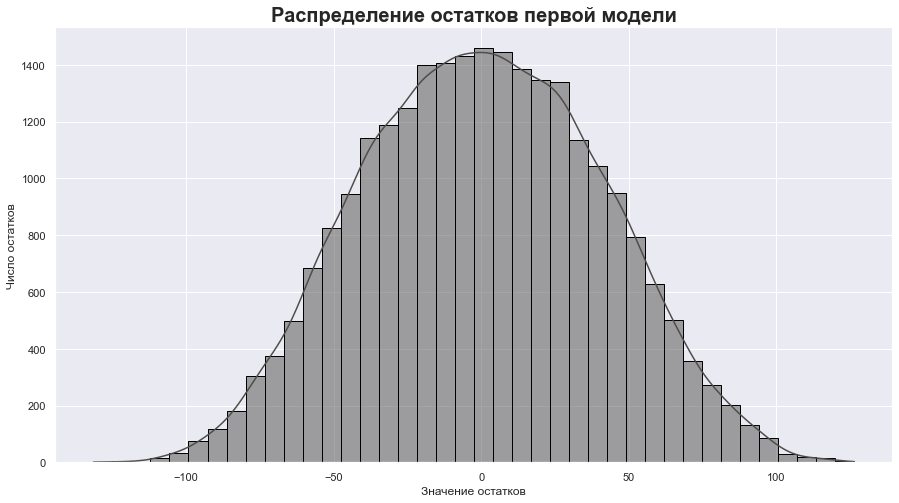

count    25000.000000
mean         0.379975
std         40.144877
min       -131.400392
25%        -29.053845
50%          0.192387
75%         29.254412
max        126.349866
Name: product, dtype: float64

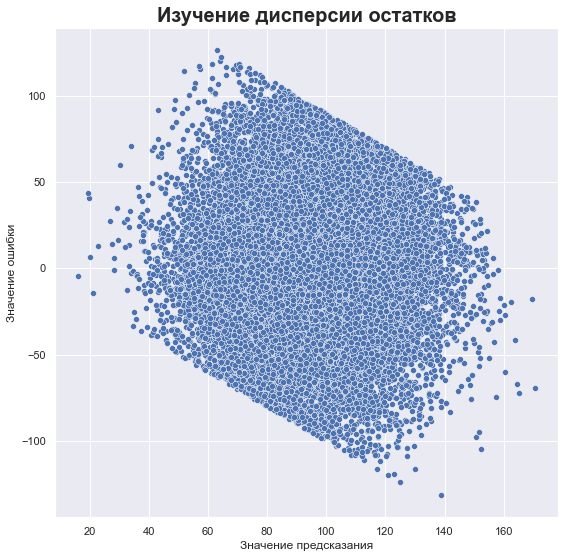

product  predictions
product      1.000000    -0.001984
predictions -0.001984     1.000000

In [59]:
residuals(y_valid_2, predictions_2)

По этим данным можно сказать, что модель работает предсказуемо, дисперсия не большая, остатки распределены нормально - без хвостов и без сдвигов. Посмотрим на среднее предсказанное значение модели и сохраним предсказания и истинные значения в один датафрейм.

In [60]:
print(f'Среднее значение предсказанного количества сырья равно {round(predictions_2.mean(), 2)}')

Среднее значение предсказанного количества сырья равно 94.77


In [61]:
results_2 = make_results_df(y_valid_2, predictions_2)
results_2.head()

product  predictions
id                            
sPjbT  117.441301    98.301916
1u4uo   47.841249   101.592461
kZ6HO   45.883483    52.449099
gCZGK  139.014608   109.922127
rqJHx   84.004276    72.411847

Третья модель полностью готова.

### Вывод по работе моделей

**geo_0**

- Модель разработанная для первого(нулевого) региона показала метрику RMSE равную 37.76 - это не плохой результат
- Остатки и их дисперсия распределены нормально - модель работает предсказуемо
- Среднее значение предсказанного объема сырья по всем точкам равно 92.4

**geo_1**

- Модель разработанная для второго региона показала метрику RMSE равную 0.89 - модель работает очень точно
- Остатки и их дисперсия распределены нормально - модель работает предсказуемо, относительно тех данных над которыми она работает
- Среднее значение предсказанного объема сырья по всем точкам равно 68.71 - это самый маленький результат по всем регионам

**geo_2**

- Модель разработанная для третьего региона показала метрику RMSE равную 40.15 - модель работает достаточно точно, но это худший показатель метрики из всех
- Остатки и их дисперсия распределены нормально - модель работает предсказуемо
- Среднее значение предсказанного объема сырья по всем точкам равно 94.77 - это самый высокий результат по всем регионам

## Подготовка к рассчету прибыли

Сначала запишем все данные необходимые для рассчетов. При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

In [62]:
points_explored = 500
selected_points = 200
budget = 10e9
revenue_per_barrel = 450e3 
risk_threshold = 0.025 

Теперь нужно рассчитать, каким объемом запасов должны обладать 200 скважин чтобы они окупили все затраты на их разработку. Для этого логично разделить бюджет выделенный на рзработку на доход с одной единицы запасов и на количиство скважин, т.е. на 200

In [63]:
break_even_volume = budget / (selected_points * revenue_per_barrel)
round(break_even_volume, 2)

111.11

Каждая скважина должна обладать запасом сырья не меньше чем 111.12 тыс. тонн для того, чтобы разработка скважин окупилась. Сравним это со средним запасом по каждому региону.

In [64]:
print(f'Средний запас сырья по первому региону равен {round(geo_0["product"].mean(), 2)} тыс. тонн')
print(f'Средний запас сырья по второму региону равен {round(geo_1["product"].mean(), 2)} тыс. тонн')
print(f'Средний запас сырья по третьему региону равен {round(geo_2["product"].mean(), 2)} тыс. тонн')

Средний запас сырья по первому региону равен 92.5 тыс. тонн
Средний запас сырья по второму региону равен 68.83 тыс. тонн
Средний запас сырья по третьему региону равен 95.0 тыс. тонн


Средний запас по каждому региону меньше чем необходимое значение, но в каждом регионе очень много точек для разработки скважин, мы же будем выбирать лучшие. Поэтому думаю, что каждый из регионов может принести прибыль. Сайчас и проверим.

## Создание функции для рассчета прибыли. Рассчет прибыли и рисков для каждого из регионов.


In [65]:
def revenue(target: pd.DataFrame, probabilities: pd.DataFrame, count: int) -> float:
    
    '''
    Функция принимает на вход истинные значения запасов, предсказанные моделью и количиство исслледуемых точек и 
    рассчитывает по ним прибыль.
    '''
    
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return revenue_per_barrel * selected.sum() - budget

Функция готова, можно переходить к рассчету рисков и прибыли для каждого региона.

### geo_0

In [66]:
state = np.random.RandomState(12345)
values = []
lost = 0
for i in range(1000):
    target_subsample = results_0['product'].sample(n=points_explored, replace=True, random_state=state)
    probs_subsample = results_0['predictions'][target_subsample.index]
    if revenue(target_subsample, probs_subsample, selected_points) < 0:
        lost += 1
    values.append(revenue(target_subsample, probs_subsample, selected_points))

values = pd.Series(values)
lower = values.quantile(0.025)
upper = values.quantile(0.975)
mean = values.mean()
risk = lost / 1000
print('Средняя выручка первого региона равен', round(mean, 2))
print(f'Нижнаяя граница доверительного интервала для первого региона равна {round(lower, 2)}')
print(f'Верхняя граница доверительного интервала для первого региона равна {round(upper, 2)}')
print(f'Риск убытков для первого региона равен {risk*100}%')

Средняя выручка первого региона равен 435933772.14
Нижнаяя граница доверительного интервала для первого региона равна -116231612.78
Верхняя граница доверительного интервала для первого региона равна 966504180.71
Риск убытков для первого региона равен 6.1%


Для первого региона риск убытков слишком высокий, по условию задачи он должен быть менее 2.5%. Проверим остальные регионы.

### geo_1

In [67]:
values = []
lost = 0
for i in range(1000):
    target_subsample = results_1['product'].sample(n=points_explored, replace=True, random_state=state)
    probs_subsample = results_1['predictions'][target_subsample.index]
    if revenue(target_subsample, probs_subsample, selected_points) < 0:
        lost += 1
    values.append(revenue(target_subsample, probs_subsample, selected_points))

values = pd.Series(values)
lower = values.quantile(0.025)
upper = values.quantile(0.975)
mean = values.mean()
risk = lost / 1000
print('Средняя выручка для второго региона равен', round(mean, 2))
print(f'Нижнаяя граница доверительного интервала для второго региона равна {round(lower, 2)}')
print(f'Верхняя граница доверительного интервала для второго региона равна {round(upper, 2)}')
print(f'Риск убытков для второго региона равен {risk*100}%')

Средняя выручка для второго региона равен 498569016.92
Нижнаяя граница доверительного интервала для второго региона равна 75315573.09
Верхняя граница доверительного интервала для второго региона равна 911503695.02
Риск убытков для второго региона равен 1.0%


Хоть во втором регионе и было больше всего скважин в которых нулевые запасы, в этом регионе риск удовлетворяет условию задачи, и даже нижняя граница доверительного интервала положительная - это говорит о том, что этот регион с большой долей вероятности не принесет убытков заказчику. Проверим третий регион.

### geo_2

In [68]:
values = []
lost = 0
for i in range(1000):
    target_subsample = results_2['product'].sample(n=points_explored, replace=True, random_state=state)
    probs_subsample = results_2['predictions'][target_subsample.index]
    if revenue(target_subsample, probs_subsample, selected_points) < 0:
        lost += 1
    values.append(revenue(target_subsample, probs_subsample, selected_points))

values = pd.Series(values)
lower = values.quantile(0.025)
upper = values.quantile(0.975)
mean = values.mean()
risk = lost / 1000
print('Средняя выручка для третьего региона равен', round(mean, 2))
print(f'Нижнаяя граница доверительного интервала для третьего региона равна {round(lower, 2)}')
print(f'Верхняя граница доверительного интервала для третьего региона равна {round(upper, 2)}')
print(f'Риск убытков для второго региона равен {round(risk*100, 5)}%')

Средняя выручка для третьего региона равен 412672898.99
Нижнаяя граница доверительного интервала для третьего региона равна -158939515.76
Верхняя граница доверительного интервала для третьего региона равна 978191201.7
Риск убытков для второго региона равен 7.0%


Риск убытков В третьем регионе тоже очень высокий, поэтому этот регион нам не подходит.

### Вывод по рассчету прибыли и рисков по регионам.

Самым прибыльным и безопасным для денег заказчика является второй регион. Средняя прибыль во втором регионе показала самый высокий результат. Риски в нем удовлетворяют условию заказчика, риск убытка равен 1.3%, когда в двух других регионах они равны 6.1%. Средняя прибыл во втором регионе должна составить порядка 501.3 млн. рублей, когда в других регионах средняя прибыль гораздо меньше 400 млн. рублей. Во втором регионе даже нижняя граница доверительного интервала это все еще прибыль для заказчика, когда в первом и третьем регионе эта граница является убытками в сотни млн. рублей. 

**Вывод:** следует разрабатывать скважины во втором регионе, так как он самый безопасный.

# Общий вывод

1. **Предобработка данных**
    - **geo_0**

        - Только признак f2 распределен нормально, но другие распределения мы никак отредактировать не можем, потому что по условию задачи не сказано, что это за признаки, следовательно мы не можем судить как они должны быть распределены.
        - Среднее значение объема запасов равно - 92.5, медианное - 91.849972

     - **geo_1**

        - Параметр f1 единственный, который распределен нормально. Параметр f0 имеет два пика, а вот данные в f2 и product похожи на исскуственно сгенерированные, но опять же мы не можем ничего сказать, потому что мы не знаеем, что это за признаки и как они могут быть распределены.
        - В данном датафрейме много нулевых значений показателя объема запасов
        - Среднее занчение объема запасов равно - 68.825, медианное - 57.085625, достаточно большой разброс

    - **geo_2**

        - Этот датафрейм отличается от других тем, что все признаки (f0, f1, f2) распределены нормально, а f0, f2, даже без смещения.
        - Среднее значение объема запаосов рано - 95, медианное - 94.925613      
2. **Исследовательский анализ**
    
    - **geo_0**

        - Небольшая зависимость есть только между целевым признаком и параметром f2
        - Точки у которых значение параметра f0 примерно меньше 0 не имеют значений объема запасов больше 160
        - Точки у которых значение параметра f0 примерно больше 1 не имеют значений объема запасов меньше 25
        - Точки у которых значение параметра f0 примерно меньше 0 не имеют значений объема запасов меньше 25
        - Точки у которых значение параметра f0 примерно больше 0.5 не имеют значений объема запасов больше 160

    - **geo_1**

        - Все данные очень похоже на исскуственно сгенерированные
        - Парметры f0 и f1 не имеют никакой зависимости с целевым признаком
        - Параметр f2 имет явную линейную зависимость с целевым прихнаком, чем больше f2, тем больше значение объемов запасов

    - **geo_2**

        - Точки запасы которых не превышают 25-30 имеют диапозон значений параметров f0 и f1 от -2 до 2, линейная зависимость отсутсвует
        - Целевой признак имет небольшую линейную зависимость от параметра f2, проще говоря чем больше f2, тем больше значение целевого признака.
3. **Корреляционный анализ**
    - Была изучена корреляция между каждым из параметров датафреймов
    - Мультиколлениарность в данных отсутсвует
4. **Подготовка данных и создание модели**
    - была создана функция для подготовки данных к работе модели
    - была создана функция для исследования распределения остатков и изучения их дисперсии
    
    - **geo_0**

        - Модель разработанная для первого(нулевого) региона показала метрику RMSE равную 37.76 - это не плохой результат
        - Остатки и их дисперсия распределены нормально - модель работает предсказуемо
        - Среднее значение предсказанного объема сырья по всем точкам равно 92.4

    - **geo_1**

        - Модель разработанная для второго региона показала метрику RMSE равную 0.89 - модель работает очень точно
        - Остатки и их дисперсия распределены нормально - модель работает предсказуемо, относительно тех данных над которыми она работает
        - Среднее значение предсказанного объема сырья по всем точкам равно 68.71 - это самый маленький результат по всем регионам

    - **geo_2**

        - Модель разработанная для третьего региона показала метрику RMSE равную 40.15 - модель работает достаточно точно, но это худший показатель метрики из всех
        - Остатки и их дисперсия распределены нормально - модель работает предсказуемо
        - Среднее значение предсказанного объема сырья по всем точкам равно 94.77 - это самый высокий результат по всем регионам
    - Предсказания модели и истинные значения объема сырья были сохранены в общий датафрейм, так же при помощи функции

5. **Подготовка к рассчету прибыли**
    - Было изучено сколько должно запасов быть в каждой скважине, чтобы она не принисла убытков. Это значение не менее 111.12 тыс. тонн
6. **Рассчет прибыли и рисков для каждого региона**
 - Самым прибыльным и безопасным для денег заказчика является второй регион. Средняя прибыль во втором регионе показала самый высокий результат. Риски в нем удовлетворяют условию заказчика, риск убытка равен 1.3%, когда в двух других регионах они равны 6.1%. Средняя прибыл во втором регионе должна составить порядка 501.3 млн. рублей, когда в других регионах средняя прибыль гораздо меньше 400 млн. рублей. Во втором регионе даже нижняя граница доверительного интервала это все еще прибыль для заказчика, когда в первом и третьем регионе эта граница является убытками в сотни млн. рублей. **Вывод:** следует разрабатывать скважины во втором регионе, так как он самый безопасный.